In [1]:
import pandas as pd
import numpy as np
import math
import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import matplotlib.ticker as tkr

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager as font_manager
from matplotlib import rcParams

from scipy.stats import chisquare

import scipy.stats as ss
%matplotlib inline

In [2]:
#read data from csv
data = pd.read_csv('VP_election_tallies.csv', parse_dates=[["date", "time"]])
data.sort_values(['region', 'candidate', 'date_time'], inplace=True)

In [3]:
#computed transmitted data
data = data[['date_time', 'candidate', 'region', 'count', 'increment']]
data['count_shift'] = data['count'].diff(periods=1)
data['ref'] = (data.candidate == data.candidate.shift(1)) & (data.region == data.region.shift(1)) 
data['transmitted_votes'] = data.count_shift*data.ref + data['count']*(~data.ref) 
print data[['candidate', 'region', 'count', 'count_shift', 'ref', 'transmitted_votes']][97:110]
data = data[(data.transmitted_votes>0)]

    candidate region    count  count_shift    ref  transmitted_votes
513      Leni    CAR   109018       2324.0   True             2324.0
551      Leni    CAR   109921        903.0   True              903.0
589      Leni    CAR   109921          0.0   True                0.0
4         BBM    NCR  1972875    1862954.0  False          1972875.0
42        BBM    NCR  2029716      56841.0   True            56841.0
80        BBM    NCR  2042715      12999.0   True            12999.0
118       BBM    NCR  2042715          0.0   True                0.0
156       BBM    NCR  2059239      16524.0   True            16524.0
194       BBM    NCR  2059239          0.0   True                0.0
232       BBM    NCR  2072344      13105.0   True            13105.0
270       BBM    NCR  2072344          0.0   True                0.0
629       BBM    NCR  2095573      23229.0   True            23229.0
667       BBM    NCR  2101255       5682.0   True             5682.0


In [4]:
#define cut (2016/5/9 3am)
cut = datetime.datetime(2016, 5, 10, 3, 0)

In [5]:
#clean data and separate at the defined cut
data_after_3am = data[(data.date_time>=cut)&(data.transmitted_votes>0)]
data_before_3am = data[(data.date_time<cut)&(data.transmitted_votes>0)]

#get votes
votes_before_3am = data_before_3am['transmitted_votes'].tolist()
votes_after_3am = data_after_3am['transmitted_votes'].tolist()
votes_before_3am = data_before_3am['transmitted_votes'].tolist()
votes_after_3am = data_after_3am['transmitted_votes'].tolist()
votes_leni_before_3am = data_before_3am[data_before_3am.candidate=='Leni']['transmitted_votes'].tolist()
votes_leni_after_3am = data_after_3am[data_after_3am.candidate=='Leni']['transmitted_votes'].tolist()
votes_bbm_before_3am = data_before_3am[data_before_3am.candidate=='BBM']['transmitted_votes'].tolist()
votes_bbm_after_3am = data_after_3am[data_after_3am.candidate=='BBM']['transmitted_votes'].tolist()

In [6]:
#define digit retriever
def get_digits(votes):
    """Retrieves first and last digit of a number"""
    first_digits = []
    last_digits = []
    for i in votes:
        first_digits.append(int(str(int(i))[0]))
        last_digits.append(int(str(int(i))[-1]))
    return first_digits, last_digits

In [7]:
#store first and last digits of the votes
first_digits_before_3am, last_digits_before_3am = get_digits(votes_before_3am)
first_digits_after_3am, last_digits_after_3am = get_digits(votes_after_3am)
first_digits_leni_before_3am, last_digits_leni_before_3am = get_digits(votes_leni_before_3am)
first_digits_leni_after_3am, last_digits_leni_after_3am = get_digits(votes_leni_after_3am)
first_digits_bbm_before_3am, last_digits_bbm_before_3am = get_digits(votes_bbm_before_3am)
first_digits_bbm_after_3am, last_digits_bbm_after_3am = get_digits(votes_bbm_after_3am)

In [8]:
#input expected normalized frequencies
n_expected_last = [1./9 for i in range(10)]
n_expected_first = [math.log((1.0 + 1.0/i), 10) for i in range(1,10)]

In [9]:
#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman') 

def plot_first_distrution(first_digits, title, n_expected, label=None, show=True):
    xval = [0.5 + i for i in range(1,10)]
    n, y, z = plt.hist(first_digits, bins=range(1,11), normed=1, color=['pink'], lw=1.5, label='Observed',histtype='stepfilled')
    plt.plot(xval, n_expected, 'g-', lw=3.5, label='Benford')
    plt.xlabel('First Digit', fontsize=20)
    plt.ylabel('Normalized Frequency', fontsize=20)
    plt.xticks(xval,range(1,10))
    plt.ylim(0, np.max(n_expected)+0.15)
    count = np.array(n)*len(first_digits)
    if label:
        plt.text(4.5, 0.26, label, fontsize=16)
    n_groups = len(n)
    label = tuple([str(i) for i in range(1,10)])
    err = tuple([0]*9)
    plt.legend(frameon=0, prop={'size':20})
    plt.tight_layout()
    print chisquare(n, f_exp=n_expected)
    if show:
        plt.show()
    else:
        plt.savefig(title,dpi=400)
    plt.clf()
    
    
def plot_last_distrution(last_digits, title, n_expected, label=None, show=True):
    xval = [i for i in range(1,11)]
    n, y, z = plt.hist(last_digits, bins=range(1,11), normed=1, color=['pink'], lw=1.5, label='Observed', histtype='stepfilled')
    plt.plot(xval, n_expected, 'g-', lw=3.5, label='Uniform')
    plt.xlabel('Last Digit', fontsize=20)
    plt.ylabel('Normalized Frequency', fontsize=20)
    plt.ylim(0, np.max(n_expected)+0.15)
    plt.xticks([0.5 + i for i in range(1,10)],range(1,10))
    if label:
        plt.text(4, 0.02, label, fontsize=16)
    n_groups = len(n)
    label = tuple([str(i) for i in range(1,10)])
    err = tuple([0]*9)
    plt.legend(frameon=0, prop={'size':20})
    plt.tight_layout()    
    print chisquare(n, f_exp=n_expected[:-1])
    if show:
        plt.show()
    else:
        plt.savefig(title,dpi=400)
    plt.clf()

first and last digit distribution of the votes transmitted
Power_divergenceResult(statistic=0.0099750215438430441, pvalue=0.99999999997432021)


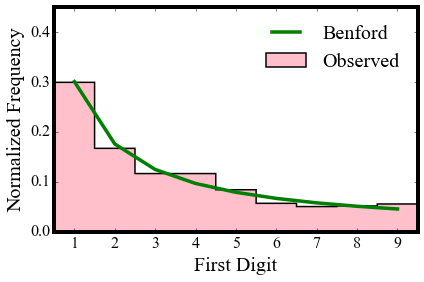

Power_divergenceResult(statistic=0.012890677141930934, pvalue=0.99999999992846267)


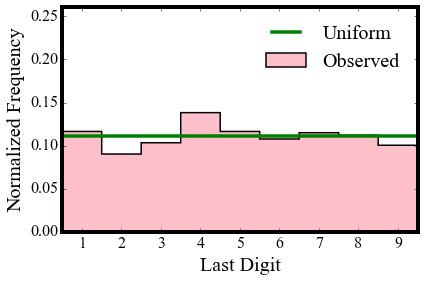

In [10]:
print "first and last digit distribution of the votes transmitted"
plot_first_distrution(first_digits_before_3am + first_digits_after_3am, 'FirstDigitsDist_FullSample', n_expected_first)
plot_last_distrution(last_digits_before_3am + last_digits_after_3am, 'LastDigitsDist_FullSample', n_expected_last)

first and last digit distribution of the votes transmitted before 3am
Power_divergenceResult(statistic=0.021451554472177215, pvalue=0.99999999945326357)


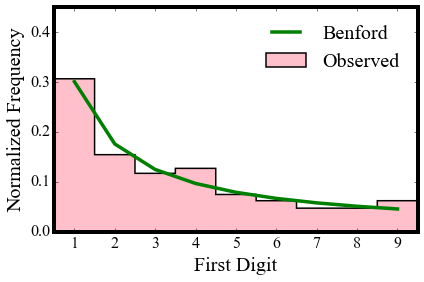

Power_divergenceResult(statistic=0.010518407212622089, pvalue=0.9999999999682575)


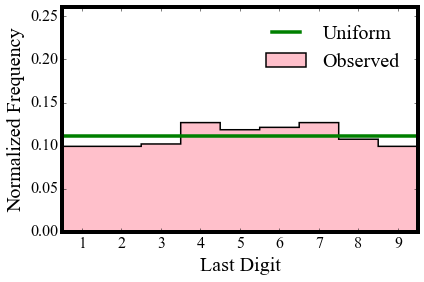

In [11]:
print "first and last digit distribution of the votes transmitted before 3am"
plot_first_distrution(first_digits_before_3am, 'FirstDigitsDist_pre3AM', n_expected_first)
plot_last_distrution(last_digits_before_3am, 'LastDigitsDist_pre3AM', n_expected_last)

Power_divergenceResult(statistic=0.0094698976835995586, pvalue=0.99999999997913569)


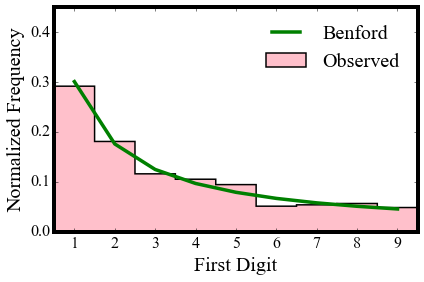

Power_divergenceResult(statistic=0.033950617283950629, pvalue=0.99999999658678751)


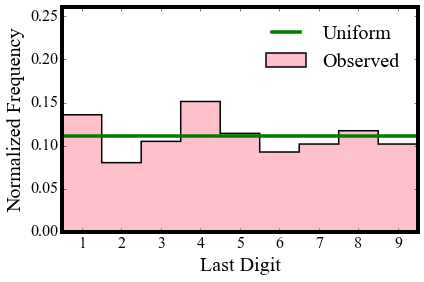

In [12]:
#first and last digit distribution of the votes transmitted after 3am
plot_first_distrution(first_digits_after_3am, 'FirstDigitsDist_post3AM', n_expected_first)
plot_last_distrution(last_digits_after_3am, 'LastDigitsDist_post3AM', n_expected_last)

Power_divergenceResult(statistic=0.056756672098637252, pvalue=0.99999997358312176)


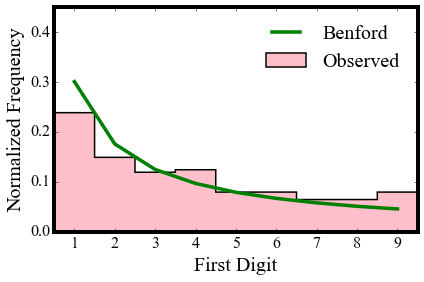

Power_divergenceResult(statistic=0.023333333333333321, pvalue=0.9999999992352433)


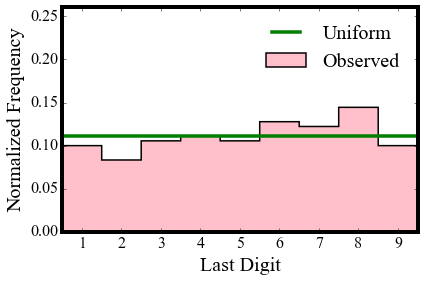

In [13]:
#first and last digit distribution of Leni's votes before 3AM
plot_first_distrution(first_digits_leni_before_3am, 'FirstDigitsDist_pre3AM_leni', n_expected_first)
plot_last_distrution(last_digits_leni_before_3am, 'LastDigitsDist_pre3AM_leni', n_expected_last)

Power_divergenceResult(statistic=0.042885591592785717, pvalue=0.99999999134101325)


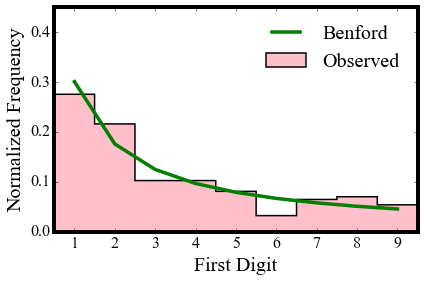

Power_divergenceResult(statistic=0.048925619834710728, pvalue=0.99999998536750645)


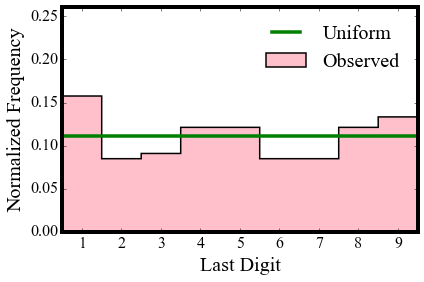

In [14]:
#first and last digit distribution of Leni's votes after 3AM
plot_first_distrution(first_digits_leni_after_3am, 'FirstDigitsDist_post3AM_leni', n_expected_first)
plot_last_distrution(last_digits_leni_after_3am, 'LastDigitsDist_post3AM_leni', n_expected_last)

first and last digit distribution of BBM's votes before 3AM
Power_divergenceResult(statistic=0.06226589461570204, pvalue=0.99999996181800355)


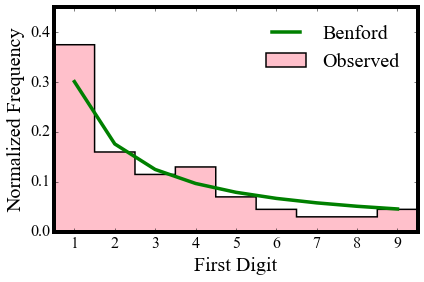

Power_divergenceResult(statistic=0.034936844934157496, pvalue=0.99999999617407787)


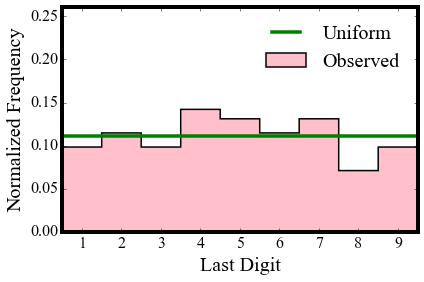

In [15]:
print "first and last digit distribution of BBM's votes before 3AM"
plot_first_distrution(first_digits_bbm_before_3am, 'FirstDigitsDist_pre3AM_bbm', n_expected_first)
plot_last_distrution(last_digits_bbm_before_3am, 'LastDigitsDist_pre3AM_bbm', n_expected_last)

first and last digit distribution of BBM's votes after 3AM
Power_divergenceResult(statistic=0.022649442236611125, pvalue=0.99999999932085115)


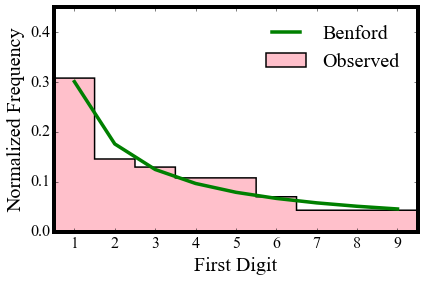

Power_divergenceResult(statistic=0.07547169811320753, pvalue=0.99999991802097488)


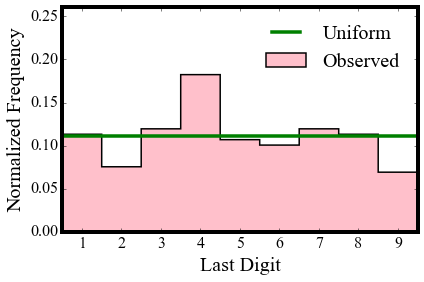

In [16]:
print "first and last digit distribution of BBM's votes after 3AM"
plot_first_distrution(first_digits_bbm_after_3am, 'FirstDigitsDist_post3AM_bbm', n_expected_first)
plot_last_distrution(last_digits_bbm_after_3am, 'LastDigitsDist_post3AM_bbm', n_expected_last)

In [17]:
#generate time partitions
cut_list = [datetime.datetime(2016, 5, 9, 20, 0)]
for i in range(11):
    cut_list.append(cut_list[-1] + datetime.timedelta(hours=2))

#data in time partitions    
partitioned_data = []
for i in range(1, len(cut_list)):
    partitioned_data.append(data[(data.date_time>=cut_list[i-1])&(data.date_time<cut_list[i])])
    
#label partitions
pre_label = np.array([_.strftime("%B %d %I%p") for _ in cut_list])
label = ['{0} to {1}'.format(pre_label[i-1], pre_label[i]) for i in range(1,len(pre_label))]

0
Power_divergenceResult(statistic=0.28475167353377528, pvalue=0.99998471780196607)


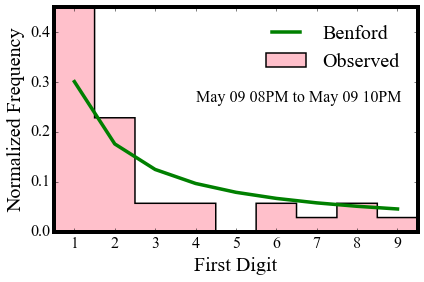

1
Power_divergenceResult(statistic=0.052360940148869752, pvalue=0.99999998083069064)


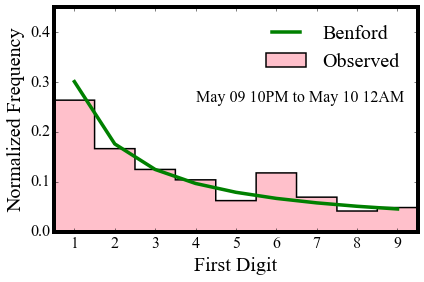

2
Power_divergenceResult(statistic=0.070982512164972408, pvalue=0.99999993573853518)


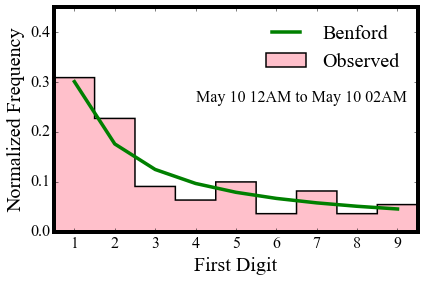

3
Power_divergenceResult(statistic=0.13495612954523162, pvalue=0.99999918149484179)


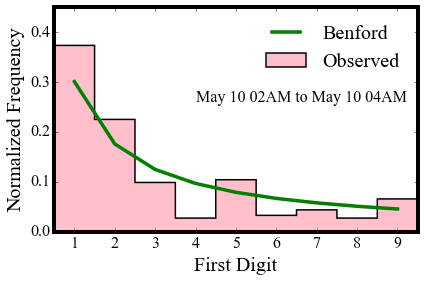

4
Power_divergenceResult(statistic=0.14539319484180901, pvalue=0.99999890195929686)


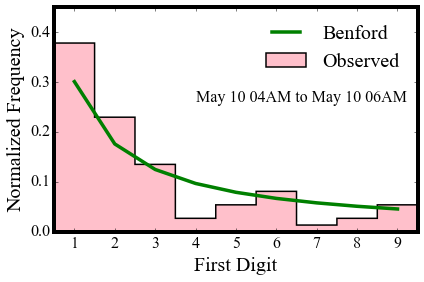

5
Power_divergenceResult(statistic=0.29481511332765076, pvalue=0.9999825103948069)


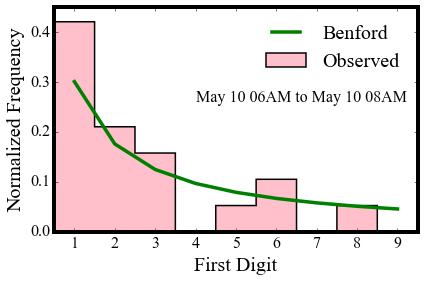

6
Power_divergenceResult(statistic=0.20319321070660712, pvalue=0.99999590675831418)


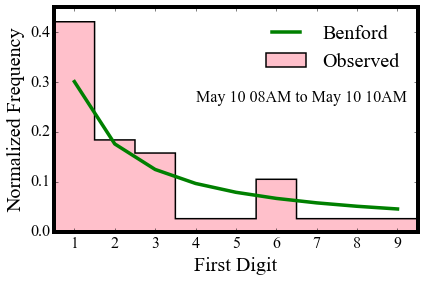

7
Power_divergenceResult(statistic=0.15486388709889362, pvalue=0.99999859200322772)


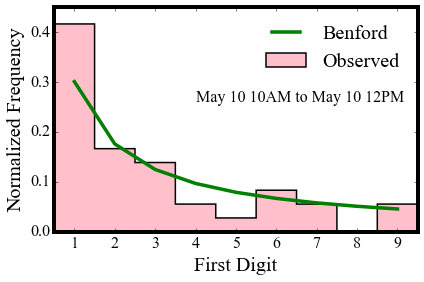

8
Power_divergenceResult(statistic=0.14859564050609872, pvalue=0.99999880350347081)


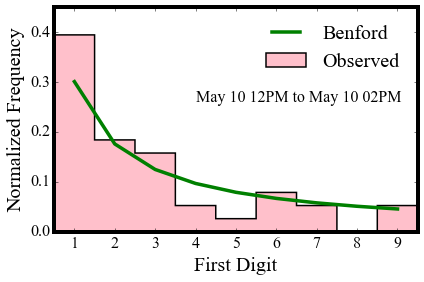

9
Power_divergenceResult(statistic=0.13756718953316716, pvalue=0.99999911720905332)


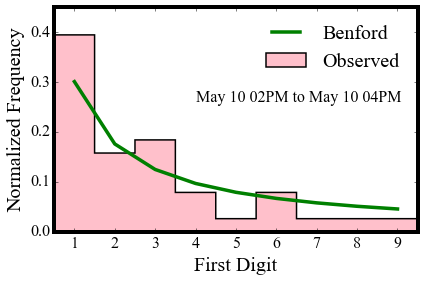

10
Power_divergenceResult(statistic=0.15399580929981044, pvalue=0.99999862283157936)


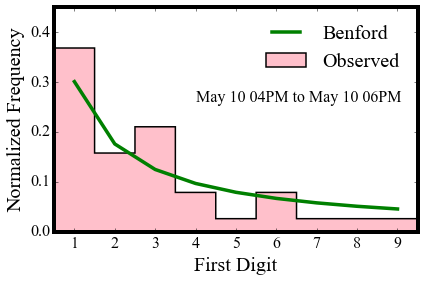

In [18]:
#generate gif
num = 0
for i in partitioned_data:
    print num
    votes = i[i.increment>0]['increment'].tolist()
    first_digits, last_digits = get_digits(votes)
    plot_first_distrution(first_digits, 'first_{0}'.format(num), n_expected_first, label=label[num])
    num = num + 1